### Serving graph with remote

#### Set up project

In [1]:
import mlrun
import os

# Create the project:
project_name='realtime-pipelines'
project_dir = os.path.abspath('./')
project = mlrun.new_project(project_name, project_dir)

# Set the environment:
mlrun.set_environment(project=project.metadata.name)

> 2022-06-18 03:01:48,744 [info] loaded project realtime-pipelines from MLRun DB


('realtime-pipelines', 'v3io:///projects/{{run.project}}/artifacts')

#### Deploy a remote function

In [2]:
# mlrun: start-code

In [3]:
import mlrun
import time
import datetime

def remote_echo(context, event):
    context.logger.info('This is an unstructured log')
    if isinstance(event.body, (str,bytes) ):
        event.body = json.loads(event.body)
    time.sleep(1)
    print(f'\nIn remote-echo {datetime.datetime.now()}')
    print(f'\In remote-echo {event}\n')
    return context.Response(body=event.body,
                            headers={},
                            content_type='text/plain',
                            status_code=200)

In [4]:
# mlrun: end-code

In [5]:
fn = mlrun.code_to_function(name='a-remote-echo', 
                            kind='nuclio',
                            image="mlrun/mlrun",
                            handler='remote_echo',
                            with_doc=False
                           )

In [6]:
fn.apply(mlrun.platforms.auto_mount())
addr = fn.deploy()

> 2022-06-18 02:52:34,847 [info] Starting remote function deploy
2022-06-18 02:52:35  (info) Deploying function
2022-06-18 02:52:35  (info) Building
2022-06-18 02:52:35  (info) Staging files and preparing base images
2022-06-18 02:52:35  (info) Building processor image
2022-06-18 02:53:30  (info) Build complete
2022-06-18 02:53:52  (info) Function deploy complete
> 2022-06-18 02:53:52,493 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-remote-serving-a-remote-echo.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['remote-serving-a-remote-echo-remote-serving.default-tenant.app.uss-sales-341.iguazio-cd1.com/']}


In [7]:
print(addr)

http://remote-serving-a-remote-echo-remote-serving.default-tenant.app.uss-sales-341.iguazio-cd1.com/


#### Define a function in the graph

In [8]:
# mlrun: start-code

In [9]:
import mlrun
import time
import datetime

def echo(event):
    time.sleep(1)
    print(datetime.datetime.now())
    print(f'\nIn echo {datetime.datetime.now()}')
    print(f'In echo {event}\n')
    return event

In [10]:
# mlrun: end-code

#### Create a graph that have the remote function in the graph

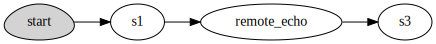

In [11]:
function = mlrun.code_to_function("test-remote-graph", kind="serving", image="mlrun/mlrun")
flow = function.set_topology("flow", engine="async")
flow.to(name="s1", handler="echo")\
     .to("$remote", "remote_echo", url=addr)\
     .to(name="s3", handler="echo").respond()

flow.plot(rankdir='LR')

#### Test the graph with mock server

In [12]:
server = function.to_mock_server()
# print(f"\nFlow:\n{flow.to_yaml()}")
resp = server.test(body={"x": 1})
server.wait_for_completion()
print(f'resp: {resp}')
print(datetime.datetime.now())

2022-06-18 02:56:17.472343

In echo 2022-06-18 02:56:17.472860
In echo {'x': 1}

2022-06-18 02:56:19.481307

In echo 2022-06-18 02:56:19.481452
In echo {'x': 1}

resp: {'x': 1}
2022-06-18 02:56:19.483457


#### Deploy the graph

In [13]:
function.apply(mlrun.platforms.auto_mount())
function.verbose=False

In [14]:
function.deploy()

> 2022-06-18 02:56:29,529 [info] Starting remote function deploy
2022-06-18 02:56:29  (info) Deploying function
2022-06-18 02:56:29  (info) Building
2022-06-18 02:56:29  (info) Staging files and preparing base images
2022-06-18 02:56:29  (info) Building processor image
2022-06-18 02:57:24  (info) Build complete
2022-06-18 02:57:50  (info) Function deploy complete
> 2022-06-18 02:57:51,739 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-remote-serving-test-remote-graph.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['remote-serving-test-remote-graph-remote-serving.default-tenant.app.uss-sales-341.iguazio-cd1.com/']}


'http://remote-serving-test-remote-graph-remote-serving.default-tenant.app.uss-sales-341.iguazio-cd1.com/'

In [15]:
function.invoke(path="/", body={"x":1})

> 2022-06-18 02:57:51,805 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-remote-serving-test-remote-graph.default-tenant.svc.cluster.local:8080/'}


{'x': 1}